# 1. Setup

In [13]:
%pip install -q -r ../requirements.txt

/opt/conda/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [14]:
%pip install jax[cuda]

/opt/conda/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 44.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 MB 49.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os

# Ajoutez le chemin de votre répertoire src
sys.path.append(os.path.abspath(".."))

In [3]:
from collections.abc import Sequence
import enum
import gc

import datasets
import huggingface_hub

from src.synthid_text import detector_mean
from src.synthid_text import logits_processing
from src.synthid_text import synthid_mixin
import tensorflow as tf
import torch
import tqdm
import transformers
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

2024-12-12 23:06:32.661205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 23:06:32.673004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 23:06:32.673022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 23:06:33.083929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
class ModelName(enum.Enum):
  GPT2 = 'gpt2'
  GEMMA_2B = 'google/gemma-2b-it'
  GEMMA_7B = 'google/gemma-7b-it'
  OLMO = 'allenai/OLMo-1B'
  LLAMA = 'meta-llama/Llama-3.2-1B'

MODEL_NAME_1 = ModelName('meta-llama/Llama-3.2-1B')
MODEL_NAME_2 = ModelName('allenai/OLMo-1B')
MODEL_NAME_3 = ModelName('google/gemma-2b-it')
MODEL_NAME_4 = ModelName('gpt2')

huggingface_hub.notebook_login()

In [7]:
DEVICE = (
    torch.device('cpu') if torch.cuda.is_available() else torch.device('cpu')
)
DEVICE

device(type='cpu')

In [9]:
CONFIG = synthid_mixin.DEFAULT_WATERMARKING_CONFIG
CONFIG

immutabledict({'ngram_len': 5, 'keys': [654, 400, 836, 123, 340, 443, 597, 160, 57, 29, 590, 639, 13, 715, 468, 990, 966, 226, 324, 585, 118, 504, 421, 521, 129, 669, 732, 225, 90, 960], 'sampling_table_size': 65536, 'sampling_table_seed': 0, 'context_history_size': 1024, 'device': device(type='cuda', index=0)})

In [10]:
BATCH_SIZE = 8
NUM_BATCHES = 320
OUTPUTS_LEN = 1024
TEMPERATURE = 0.5
TOP_K = 40
TOP_P = 0.99

tokenizer_1 = transformers.AutoTokenizer.from_pretrained(MODEL_NAME_1.value)
tokenizer_1.pad_token = tokenizer_1.eos_token
tokenizer_1.padding_side = "left"

tokenizer_2 = transformers.AutoTokenizer.from_pretrained(MODEL_NAME_2.value)
tokenizer_2.pad_token = tokenizer_2.eos_token
tokenizer_2.padding_side = "left"

tokenizer_3 = transformers.AutoTokenizer.from_pretrained(MODEL_NAME_3.value)
tokenizer_3.pad_token = tokenizer_3.eos_token
tokenizer_3.padding_side = "left"

tokenizer_4 = transformers.AutoTokenizer.from_pretrained(MODEL_NAME_4.value)
tokenizer_4.pad_token = tokenizer_4.eos_token
tokenizer_4.padding_side = "left"

logits_processor = logits_processing.SynthIDLogitsProcessor(
    **CONFIG, top_k=TOP_K, temperature=TEMPERATURE
)

In [19]:
from hf_olmo import OLMoForCausalLM

def load_model(
    model_name: ModelName,
    expected_device: torch.device,
    enable_watermarking: bool = False,
) -> transformers.PreTrainedModel:
  if model_name == ModelName.GPT2:
    model_cls = (
        synthid_mixin.SynthIDGPT2LMHeadModel
        if enable_watermarking
        else transformers.GPT2LMHeadModel
    )
    model = model_cls.from_pretrained(model_name.value)
  elif model_name == ModelName.GEMMA_2B or model_name == ModelName.GEMMA_7B:
    model_cls = (
        synthid_mixin.SynthIDGemmaForCausalLM
        if enable_watermarking
        else transformers.GemmaForCausalLM
    )
    
    model = model_cls.from_pretrained(
        model_name.value,
        device_map='auto',
        torch_dtype=torch.bfloat16,
    )
  elif model_name == ModelName.OLMO:
      model_cls = (
          synthid_mixin.SynthIDOlmoForCausalLM
          if enable_watermarking
          else OLMoForCausalLM
      )
      model = model_cls.from_pretrained(
          model_name.value,
          revision="step20000-tokens84B",
          device_map='cuda:0',
          torch_dtype=torch.bfloat16
      )
  elif model_name == ModelName.LLAMA:
    model_cls = (
        synthid_mixin.SynthIDLlamaForCausalLM
        if enable_watermarking
        else transformers.LlamaForCausalLM
    )
    model = model_cls.from_pretrained(
        model_name.value,
        device_map="auto",
        torch_dtype=torch.bfloat16,
    )
  else:
      model_cls = (
          synthid_mixin.SynthIDAutoModelForCausalLM
          if enable_watermarking
          else transformers.AutoModelForCausalLM
      )
      model = model_cls.from_pretrained(
          model_name.value,
          device_map='auto',
          torch_dtype=torch.bfloat16
      )    


  if str(model.device) != str(expected_device):
    raise ValueError('Model device not as expected.')

  return model

## Benchmarking watermark detection with Mean Detector
In order to find out the impact of the watermarking algorithm on the different models, we decide to do the following:
We make the temperature of each model vary from 0.1 to 1.0, and check the Mean scores of each response, while generating responses that are sometimes watermarked, sometimes not.
We then plot the Means to the temperature and compare them to the changes with and without watermarking in order to visualize if there is a visible difference between one and the other.

In [12]:
NUM_NEGATIVES = 10000
POS_BATCH_SIZE = 32
NUM_POS_BATCHES = 313
NEG_BATCH_SIZE = 32
# Truncate outputs to this length for training.
POS_TRUNCATION_LENGTH = 200
NEG_TRUNCATION_LENGTH = 200
# Pad trucated outputs to this length for equal shape across all batches.
MAX_PADDED_LENGTH = 1000

In [13]:
def generate_responses(example_inputs, enable_watermarking, tokenizer, model_name, temperature):
  inputs = tokenizer(
      example_inputs,
      return_tensors='pt',
      padding=True,
      return_token_type_ids=False
  ).to(DEVICE)

  gc.collect()
  torch.cuda.empty_cache()

  model = load_model(
      model_name,
      expected_device=DEVICE,
      enable_watermarking=enable_watermarking,
  )
  torch.manual_seed(0)
  _, inputs_len = inputs['input_ids'].shape

  outputs = model.generate(
      **inputs,
      do_sample=True,
      max_length=inputs_len + OUTPUTS_LEN,
      temperature=temperature,
      top_k=TOP_K,
      top_p=TOP_P,
      pad_token_id=tokenizer.eos_token_id,
  )

  outputs = outputs[:, inputs_len:]

  # eos mask is computed, skip first ngram_len - 1 tokens
  # eos_mask will be of shape [batch_size, output_len]
  eos_token_mask = logits_processor.compute_eos_token_mask(
      input_ids=outputs,
      eos_token_id=tokenizer.eos_token_id,
  )[:, CONFIG['ngram_len'] - 1 :]

  # context repetition mask is computed
  context_repetition_mask = logits_processor.compute_context_repetition_mask(
      input_ids=outputs,
  )
  # context repitition mask shape [batch_size, output_len - (ngram_len - 1)]

  combined_mask = context_repetition_mask * eos_token_mask

  g_values = logits_processor.compute_g_values(
      input_ids=outputs,
  )
  # g values shape [batch_size, output_len - (ngram_len - 1), depth]
    
  del inputs, outputs, model
  # gc.collect()
  # torch.cuda.empty_cache()
  return g_values, combined_mask

example_inputs = [
    'I enjoy walking with my cute dog',
    'I am from New York',
    'The test was not so very hard after all',
    "I don't think they can score twice in so short a time",
]

## Visualizing 

In [14]:
sns.set_theme(style="darkgrid")
def plot_benchmarking_results(results, temperature_values, model):
    os.makedirs("../data", exist_ok=True)
    save_file = os.path.join("../data", model)
    
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='black')
    ax.set_facecolor('black')

    # Use a color palette suitable for two lines
    palette = sns.color_palette("coolwarm", 2)
    palette_index = 0
    for model_name, scores in results.items():
        ax.plot(
            temperature_values,
            scores["watermarked"],
            label=f"{model_name} (Watermarked)",
            linestyle='--',
            color=palette[0]
        )
        ax.plot(
            temperature_values,
            scores["unwatermarked"],
            label=f"{model_name} (Unwatermarked)",
            color=palette[1]
        )

    # Customize plot appearance
    ax.set_xlabel("Temperature", color='white')
    ax.set_ylabel("Mean Scores", color='white')
    ax.set_title("Benchmarking Mean Scores by Temperature and Watermarking", color='white')
    ax.legend(facecolor='black', edgecolor='white', labelcolor='white')
    ax.grid(color='gray', linestyle='--', linewidth=0.5)

    # Set axis limits and ticks
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    
    plt.savefig(save_file)
    plt.show()

In [15]:
def save_results_to_numpy(results, folder_path="../data"):
    for model_name, scores in results.items():
        model_folder = os.path.join(folder_path, model_name)
        os.makedirs(model_folder, exist_ok=True)
        
        np.save(os.path.join(model_folder, f"watermarked.npy"), scores["watermarked"])
        np.save(os.path.join(model_folder, f"unwatermarked.npy"), scores["unwatermarked"])


In [20]:
temperature_values = np.linspace(0.1, 1.0, 10)
results = {}

for model_name, tokenizer in [
    #(MODEL_NAME_1, tokenizer_1),
    #(MODEL_NAME_2, tokenizer_2),
    #(MODEL_NAME_3, tokenizer_3),
    (MODEL_NAME_4, tokenizer_4),
]:
    wm_scores = []
    uwm_scores = []

    for temp in tqdm.tqdm(temperature_values, desc=f"Temperatures for {model_name}", leave=False):
        TEMPERATURE = temp
        logits_processor = logits_processing.SynthIDLogitsProcessor(
            **CONFIG, top_k=TOP_K, temperature=TEMPERATURE
        )

        wm_g_values, wm_mask = generate_responses(
            example_inputs, enable_watermarking=True, tokenizer=tokenizer, model_name=model_name, temperature=temp
        )
        uwm_g_values, uwm_mask = generate_responses(
            example_inputs, enable_watermarking=False, tokenizer=tokenizer, model_name=model_name, temperature=temp
        )

        wm_mean_scores = detector_mean.mean_score(
            wm_g_values.cpu().numpy(), wm_mask.cpu().numpy()
        )
        uwm_mean_scores = detector_mean.mean_score(
            uwm_g_values.cpu().numpy(), uwm_mask.cpu().numpy()
        )

        wm_scores.append(np.mean(np.array(wm_mean_scores)))
        uwm_scores.append(np.mean(np.array(uwm_mean_scores)))
        
    results[model_name.value] = {
        "watermarked": wm_scores,
        "unwatermarked": uwm_scores
    }
    save_results_to_numpy(results)

ValueError: SynthIDLogitsProcessor received inputs with unexpected device.

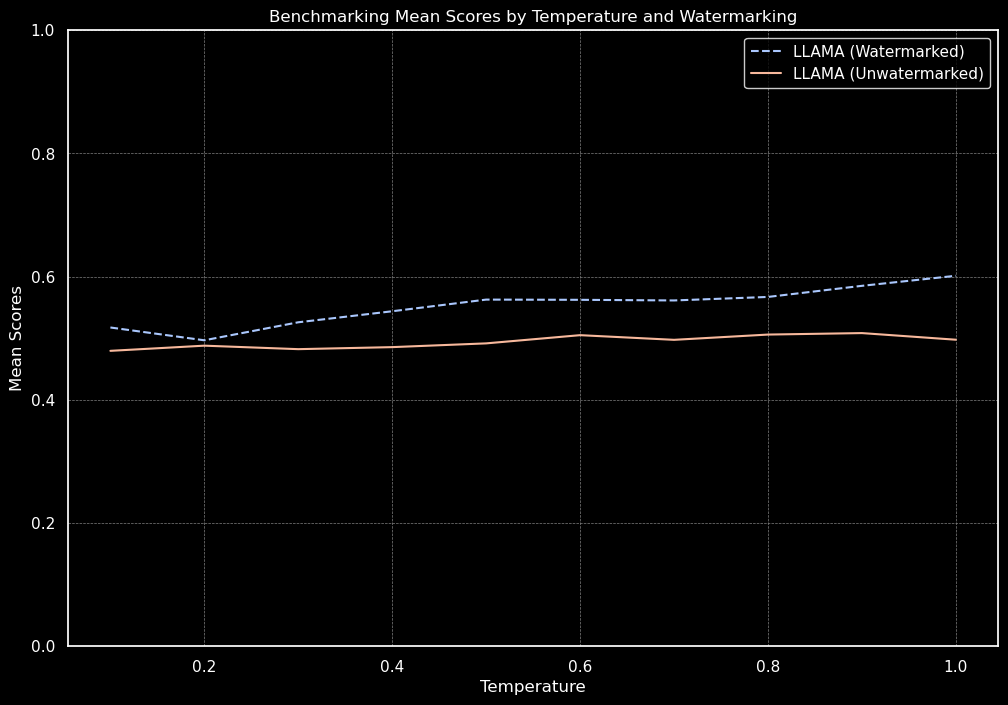

In [32]:
means = {}
uwm_results = np.load("../data/meta-llama/Llama-3.2-1B/unwatermarked.npy")
wm_results = np.load("../data/meta-llama/Llama-3.2-1B/watermarked.npy")
means["LLAMA"] = {
        "watermarked": wm_results,
        "unwatermarked": uwm_results
    }
plot_benchmarking_results(means, temperature_values.tolist(), "LLAMA")

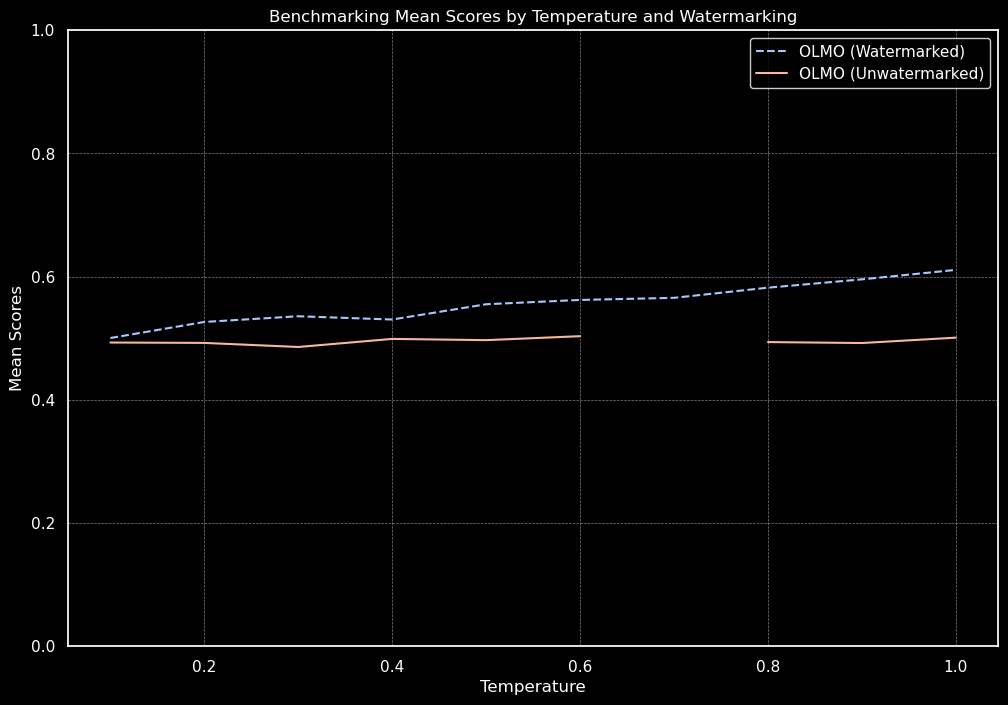

[0.49306396 0.49243674 0.48581782 0.49893206 0.4969129  0.50336516
        nan 0.49379668 0.49224335 0.5009674 ]


In [13]:
means = {}
uwm_results = np.load("../data/allenai/OLMo-1B/unwatermarked.npy")
wm_results = np.load("../data/allenai/OLMo-1B/watermarked.npy")
means["OLMO"] = {
        "watermarked": wm_results,
        "unwatermarked": uwm_results
    }
plot_benchmarking_results(means, temperature_values.tolist(), "OLMO")
print(uwm_results)

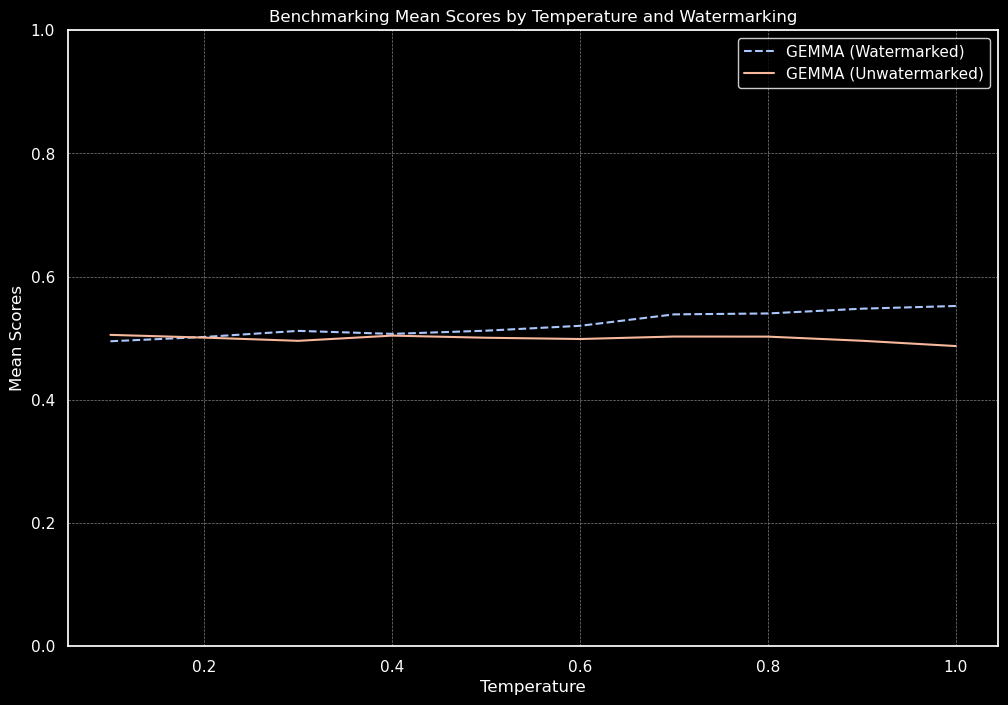

In [13]:
means = {}
uwm_results = np.load("../data/google/gemma-2b-it/unwatermarked.npy")
wm_results = np.load("../data/google/gemma-2b-it/watermarked.npy")
means["GEMMA"] = {
        "watermarked": wm_results,
        "unwatermarked": uwm_results
    }
plot_benchmarking_results(means, temperature_values.tolist(), "GEMMA")

In [ ]:
means = {}
uwm_results = np.load("../data/gpt2/unwatermarked.npy")
wm_results = np.load("../data/gpt2/watermarked.npy")
means["GPT"] = {
        "watermarked": wm_results,
        "unwatermarked": uwm_results
    }
plot_benchmarking_results(means, temperature_values.tolist(), "GPT")

In [ ]:
plot_benchmarking_results(means, temperature_values.tolist(), "ALL_PLOT")